# Importing neccesary libraries

In [1]:
import gdown
import zipfile
import pandas as pd
import random
import warnings

warnings.filterwarnings('ignore')

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf

# Downloading and storing images and data sets

## Images

In [2]:
image_url = 'https://drive.google.com/uc?id=18c43SiRTrJYjUN0cPoynA39NWx__bJDa'
image_zip = 'images.zip'

gdown.download(image_url, image_zip, quiet=False)

extracted = 'images'
with zipfile.ZipFile(image_zip, 'r') as zip_ref:
    zip_ref.extractall(extracted)

Downloading...
From: https://drive.google.com/uc?id=18c43SiRTrJYjUN0cPoynA39NWx__bJDa
To: C:\Users\malir\images.zip
100%|█████████████████████████████████████████████████████████████████████████████| 11.5M/11.5M [00:02<00:00, 4.83MB/s]


## Dataset

In [3]:
target_url = 'https://drive.google.com/uc?id=1_lwltpA4uhAchTHy7M6fe3tM_eCRGqjU'
target_csv = 'target_data.csv'

gdown.download(target_url, target_csv, quiet=False)
 
df = pd.read_csv(target_csv,sep='\t')

Downloading...
From: https://drive.google.com/uc?id=1_lwltpA4uhAchTHy7M6fe3tM_eCRGqjU
To: C:\Users\malir\target_data.csv
100%|███████████████████████████████████████████████████████████████████████████████| 134k/134k [00:00<00:00, 2.82MB/s]


# Make a list of images names to match with the data set and find the corresponding ones

In [4]:
import os
from os import listdir

pic_dir = 'images/imgs'

pic_names = []
for pic in os.listdir(pic_dir):
    pic_names.append(pic)
    
print(len(pic_names))

1764


# Check wether all images have the same resolution or not 

In [5]:
resolutions = {}
for i in pic_names:
    img = Image.open(pic_dir+f'/{i}')
    wid, hgt = img.size
    if (wid, hgt) not in resolutions:
        resolutions[(wid, hgt)] = 0 
    resolutions[(wid, hgt)] += 1 

    
resolutions

{(432, 432): 1764}

## Storing the resolution in a variable in case we need that

In [6]:
img_res = next(iter(resolutions.keys()))

# Add '.png' to the ad_clicked column and changing the data type to string so that we can check the list of images with that, and get rid of the ones that are not present amongst our images

In [7]:
df['log_id'] = df['log_id'].astype('str') + '.png'
df

,user_id,ad_clicked,attention,log_id
0,5npsk114ba8hfbj4jr3lt8jhf5,0,4,20181002033126.png
1,5o9js8slc8rg2a8mo5p3r93qm0,1,5,20181001211223.png
2,pi17qjfqmnhpsiahbumcsdq0r6,0,4,20181001170952.png
3,3rptg9g7l83imkbdsu2miignv7,0,1,20181001140754.png
4,049onniafv6fe4e6q42k6nq1n2,0,1,20181001132434.png
...,...,...,...,...
2904,2jbfmshmhsji4smrgph018k410,0,2,20170203232414.png
2905,p1tt6ehhpcihelra9j558acgv7,0,4,20170131193748.png
2906,tl1hfafsot8s5qud19bkij68f7,0,2,20170106152837.png
2907,lvmrfennsqgn49ndepfnl68ok4,0,4,20170102171535.png


## Dropping the ones that are not in our list

In [8]:
df = df.sort_values(by=['log_id'])

for i in df['log_id'].values:
    if i not in pic_names:
        df.drop(df[df['log_id'] == i].index,inplace=True)
        
df.reset_index(inplace=True,drop=True)

In [9]:
df

,user_id,ad_clicked,attention,log_id
0,2fq3fhu6r693jl2sdb8fhbd190,1,5,20161214224444.png
1,mh0d0jr0oo98kriolus0ml0591,0,2,20161215173310.png
2,hp3hqt4ifrb3q4f8vgo8e98e65,0,4,20161217041101.png
3,9k7e1d73n5reh06p705cgp2ke7,0,2,20161218020519.png
4,j25njapljcob43qrg1cfnsg452,0,4,20161219223751.png
...,...,...,...,...
1759,r79vp0b4cm4aahos39seof8ei1,0,5,20180627155928.png
1760,5rhdto3kle22lctorjr4ouqvb4,0,5,20180627181020.png
1761,58npdb91133qlb8bfoejokope3,1,4,20180627205851.png
1762,uhlg8fr2vaejph65n7crkq4ln1,0,4,20180628045013.png


In [10]:
df['ad_clicked'].value_counts()

0    1270
1     494
Name: ad_clicked, dtype: int64

#### We can clearly observe that the 72% of our data belong to 0 label and 28% belong to 1 label, which shows an imbalance in our labels

## Check if the ad_clicked column is 100 % similar to the images list

In [11]:
print(all(pic_names == df['log_id'].values))

True


# Converting the images to NumPy arrays

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pic_dir = 'images/imgs'
labels = df['ad_clicked']

# First i defiend a function to read and process the image using cv2 library
# The installation syntax using pip -> pip install numpy matplotlib opencv-python
# We will resize images from 432*432 to 128*128
def preprocess_image(pic_dir, target_size=(128, 128)):
    image = cv2.imread(pic_dir)
    
    # This step is necessary because in the documentation it's been told that OpenCV reads images in BGR format by default
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resizing to 128*128 to make the calculations and reading easier
    image = cv2.resize(image, target_size)
    
    # Most important part, normalizing pixel values to be in range of (0,1)
    image = image / 255.0  
    return image

# Images to NumPy array
image_files = [os.path.join(pic_dir, filename) for filename in os.listdir(pic_dir)]

images = [preprocess_image(file_path) for file_path in image_files]
labels = labels.values

# Split the data into train,test and validation
train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

valid_images, test_images, valid_labels, test_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=42
)


# Convert to NumPy arrays
train_images = np.array(train_images)
valid_images = np.array(valid_images)
test_images = np.array(test_images)

In [13]:
print(f"Train Images Shape -> {train_images.shape}")
print(f"Train Labels Shape -> {train_labels.shape}")
print(f"Valid Images Shape -> {valid_images.shape}")
print(f"Valid Labels Shape -> {valid_labels.shape}")
print(f"Test Images Shape -> {test_images.shape}")
print(f"Test Labels Shape -> {test_labels.shape}")

Train Images Shape -> (1234, 128, 128, 3)
Train Labels Shape -> (1234,)
Valid Images Shape -> (265, 128, 128, 3)
Valid Labels Shape -> (265,)
Test Images Shape -> (265, 128, 128, 3)
Test Labels Shape -> (265,)


# Plotting randomly some of our images

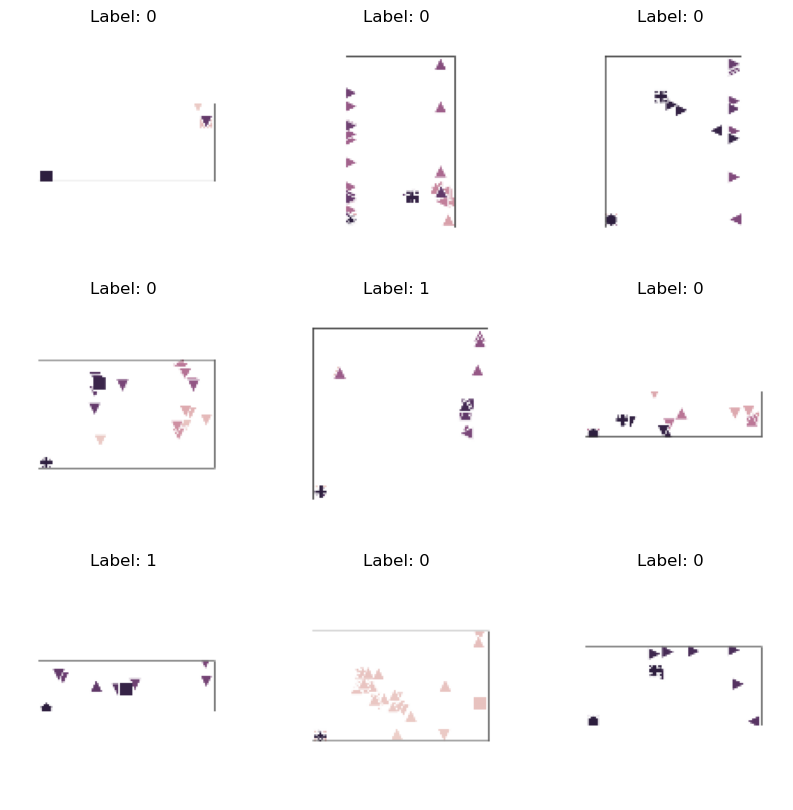

In [14]:
import matplotlib.pyplot as plt
import random

num_images = len(train_images)

# Generating 9 different random numbers to randomly illustrate some of images
random_indices = random.sample(range(num_images), 9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(3, 3, i)
    plt.imshow(train_images[idx])
    plt.title(f"Label: {train_labels[idx]}")
    plt.axis("off")

plt.show()

# Implementing the Neural Network

## First step is to import the libraries that we need, i will use the sequnetial api of keras library

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

#### First implementation is more based on gut feelings for me because this is the first time that i am handling the image processing, so i will use three convolutional layers and two dense layers, of course the last layer is our output and it will only contain one neuron with sigmoid activation, the out put of such layer can only be 0 and 1 which is suitable for our task which is a binary classification. 

In [16]:
# First create the empty model
model = Sequential()

# Very important to clear the session to avoid mixing up with and being affetced by previous computations 
tf.keras.backend.clear_session()

# First convolutional layers gets the input which is resolution and channels in our case -> (128,128,3)
# Using MaxPooling => reduce the spatial dimensions of the input,while retaining the most important information
model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu', input_shape=train_images[0].shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(64, 3, kernel_initializer='normal', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Flatten())

# Using drop which out is another regularization technique
# dropout rate = 0.45 ==> 45% of the input units will be randomly set to zero (Drop)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.45))

model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0

#### Then we compile the model with apropriate loss and optimizer, ofcourse we can decide about the loss function, becase it's a binary classification we might go with the binary crossentropy but optimizer is a hyper parameter and needs to be tuned. After compiling, finally we fit the model on our train data and see how it performs on the validation data, the loss function and accuracy are important metrics here since they show how model perform in terms of under fitting and over fitting, wether the model learns or not.

In [18]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
results = model.fit(train_images, 
             train_labels, 
             epochs=12,
             batch_size=100,
             validation_data=(valid_images, valid_labels))

Epoch 1/12


13/13 [==============================] - 11s 530ms/step - loss: 0.6083 - accuracy: 0.7229 - val_loss: 0.6252 - val_accuracy: 0.6830
Epoch 2/12
13/13 [==============================] - 5s 409ms/step - loss: 0.5915 - accuracy: 0.7293 - val_loss: 0.6179 - val_accuracy: 0.6830
Epoch 3/12
13/13 [==============================] - 5s 419ms/step - loss: 0.5793 - accuracy: 0.7293 - val_loss: 0.6183 - val_accuracy: 0.6830
Epoch 4/12
13/13 [==============================] - 6s 423ms/step - loss: 0.5696 - accuracy: 0.7293 - val_loss: 0.6071 - val_accuracy: 0.6830
Epoch 5/12
13/13 [==============================] - 5s 412ms/step - loss: 0.5613 - accuracy: 0.7293 - val_loss: 0.5858 - val_accuracy: 0.6830
Epoch 6/12
13/13 [==============================] - 5s 409ms/step - loss: 0.5480 - accuracy: 0.7293 - val_loss: 0.5640 - val_accuracy: 0.6830
Epoch 7/12
13/13 [==============================] - 5s 409ms/step - loss: 0.5255 - accuracy: 0.7310 - val_loss: 0.5592 - val_accuracy: 0.6830
Epo

#### Function for plotting loss and accuracy for train and validation data ( Copied from one of the notebooks :D )

In [19]:
def plot_results(results):
  # summarize history for accuracy
  plt.figure(figsize = (12,5))
  plt.subplot(121)
  plt.plot(results.history['accuracy'])
  plt.plot(results.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(results.history['loss'])
  plt.plot(results.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')

  max_loss = np.max(results.history['loss'])
  min_loss = np.min(results.history['loss'])
  print("Maximum Loss : {:.4f}".format(max_loss))
  print("")
  print("Minimum Loss : {:.4f}".format(min_loss))
  print("")
  print("Loss difference : {:.4f}".format((max_loss - min_loss)))

Maximum Loss : 0.6083

Minimum Loss : 0.5107

Loss difference : 0.0976


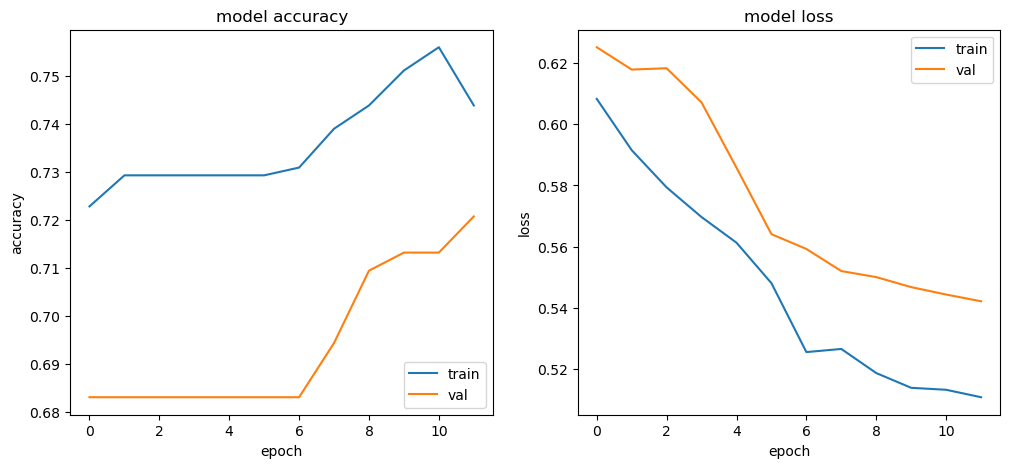

In [20]:
plot_results(results)

#### When the validation loss is higher than the training loss, it typically indicates that the model is facing overfitting, since the training accuracy is relatively high (74.31%), and the validation accuracy is lower, it shows that the model is overfitting. The model is likely learning specific patterns in the training data that do not generalize well to new data (validation data). To prevent overfitting we apply regularization techniques to tackle with large weights and i think L2 is a good choice in this case because it adds the sum of squared weights to the loss function, promoting smaller but non-zero weights and preventing extreme values, i will also increase the dropout rate to 0.5 and increase number of epochs and decrease the batch size, it will allow the model to learn from each individual example but takes longer to train.

In [21]:
# First create the empty model
model = Sequential()

# Very important to clear the session to avoid mixing up with and being affetced by previous computations 
tf.keras.backend.clear_session()

# First convolutional layers gets the input which is resolution and channels in our case -> (128,128,3)
# Using MaxPooling => reduce the spatial dimensions of the input,while retaining the most important information
model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu', input_shape=train_images[0].shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(64, 3, kernel_initializer='normal', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Flatten())

# Using drop which out is another regularization technique
# dropout rate = 0.45 ==> 45% of the input units will be randomly set to zero (Drop)
# Adding the kernel regulizer,l2 and increasing dropout rate
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0

In [23]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
results = model.fit(train_images, 
             train_labels, 
             epochs=40,
             batch_size=30,
             validation_data=(valid_images, valid_labels))

Epoch 1/40
42/42 [==============================] - 10s 162ms/step - loss: 1.6439 - accuracy: 0.7099 - val_loss: 1.4395 - val_accuracy: 0.6830
Epoch 2/40
42/42 [==============================] - 6s 141ms/step - loss: 1.2471 - accuracy: 0.7293 - val_loss: 1.1317 - val_accuracy: 0.6830
Epoch 3/40
42/42 [==============================] - 6s 143ms/step - loss: 1.0039 - accuracy: 0.7293 - val_loss: 0.9240 - val_accuracy: 0.6830
Epoch 4/40
42/42 [==============================] - 6s 141ms/step - loss: 0.8442 - accuracy: 0.7366 - val_loss: 0.8114 - val_accuracy: 0.6906
Epoch 5/40
42/42 [==============================] - 6s 140ms/step - loss: 0.7567 - accuracy: 0.7423 - val_loss: 0.7481 - val_accuracy: 0.7094
Epoch 6/40
42/42 [==============================] - 6s 140ms/step - loss: 0.6985 - accuracy: 0.7439 - val_loss: 0.7002 - val_accuracy: 0.7358
Epoch 7/40
42/42 [==============================] - 6s 140ms/step - loss: 0.6600 - accuracy: 0.7593 - val_loss: 0.6777 - val_accuracy: 0.7245
Epoch

Maximum Loss : 1.6439

Minimum Loss : 0.4695

Loss difference : 1.1743


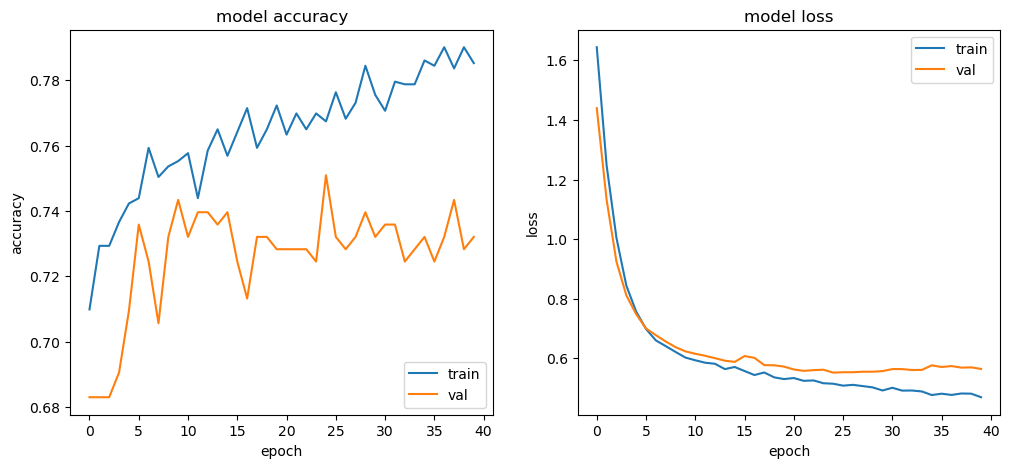

In [24]:
plot_results(results)

#### The training loss is decreasing, which is a positive sign, indicating that the model is learning from the training data. The validation loss is also decreasing, which is good. However, starting from around epoch 20, there seems to be an increase in the validation loss. This could be an indication of overfitting, and we will use a callback like earlystopping to tackle this problem, the training accuracy is increasing and has reached a high value and the validation accuracy shows some fluctuations but generally follows the training accuracy. By using early stopping it will also prevent the decreasing but fluctuating part. We can also use data augmentation technique to artificially increase the size of our training dataset and improve generalization.
#### Another important thing which may impact the result is the class imbalance, at the beginning of the data preprocessing we saw the distribution of classes was 72% for 0 label and 28% fir 1 label. Now that we are sure about the architecture of our model and some of basic hyper parameters we can calculate the weght of classes and apply that as well to see it will affect the performance or not.

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compute class weights and convert to dictionary format
class_labels = np.unique(train_labels)
class_weights = compute_class_weight(class_weight = "balanced",
                                    classes = np.unique(class_labels),
                                    y = train_labels)
class_weight_dict = dict(zip(class_labels, class_weights))

# Data augmentation using ImageDataGenerator
# It works best when we are loading data from a local directory or CSV
datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
    fill_mode='nearest'     
)

# generate augmented batches
train_datagen = datagen.flow(train_images, train_labels, batch_size=30)

results = model.fit(
    train_datagen,
    steps_per_epoch=len(train_images) // 30,
    epochs=40,
    validation_data=(valid_images, valid_labels),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/40
41/41 [==============================] - 17s 379ms/step - loss: 0.7381 - accuracy: 0.6703 - val_loss: 0.6113 - val_accuracy: 0.7132
Epoch 2/40
41/41 [==============================] - 15s 371ms/step - loss: 0.7170 - accuracy: 0.6852 - val_loss: 0.6016 - val_accuracy: 0.6981
Epoch 3/40
41/41 [==============================] - 16s 387ms/step - loss: 0.7075 - accuracy: 0.5972 - val_loss: 0.5788 - val_accuracy: 0.6981
Epoch 4/40
41/41 [==============================] - 15s 369ms/step - loss: 0.6979 - accuracy: 0.6370 - val_loss: 0.5921 - val_accuracy: 0.6642
Epoch 5/40
41/41 [==============================] - 15s 368ms/step - loss: 0.6968 - accuracy: 0.5864 - val_loss: 0.5856 - val_accuracy: 0.6906
Epoch 6/40
41/41 [==============================] - 15s 371ms/step - loss: 0.6985 - accuracy: 0.5590 - val_loss: 0.5719 - val_accuracy: 0.6981
Epoch 7/40
41/41 [==============================] - 16s 393ms/step - loss: 0.6949 - accuracy: 0.5914 - val_loss: 0.5962 - val_accuracy: 0.6755

Maximum Loss : 0.7381

Minimum Loss : 0.6793

Loss difference : 0.0588


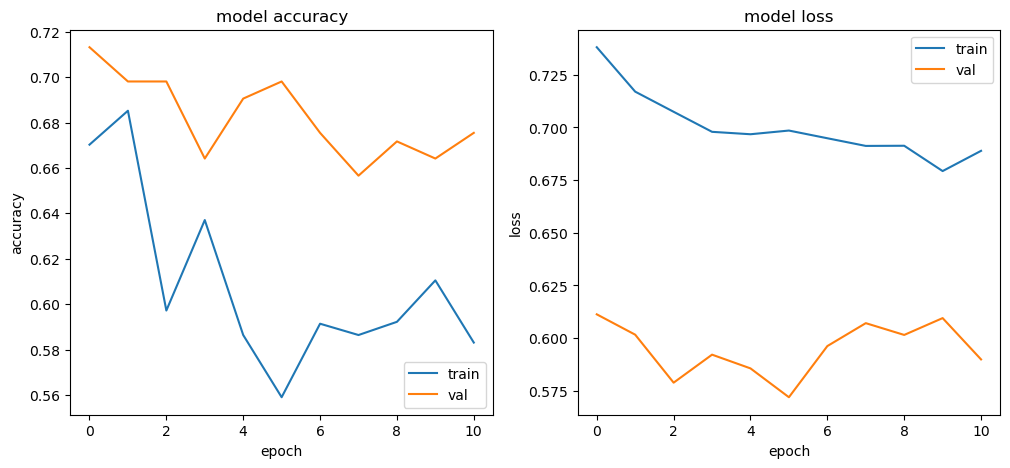

In [27]:
plot_results(results)

#### It looks like the changes didn't have a desirable impact, so far the best model was the previous one. Maybe we can find the best hyper parameters with use of grid search technique or make small changes to the architecture, so i will implement the grid search or play around with the previous model. I Will just add one other convolutional layer and one other dense layer. 

In [28]:
# First create the empty model
model = Sequential()

# Very important to clear the session to avoid mixing up with and being affetced by previous computations 
tf.keras.backend.clear_session()

# First convolutional layers gets the input which is resolution and channels in our case -> (128,128,3)
# Using MaxPooling => reduce the spatial dimensions of the input,while retaining the most important information
model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu', input_shape=train_images[0].shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(64, 3, kernel_initializer='normal', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(128, 3, kernel_initializer='normal', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Flatten())

# Using drop which out is another regularization technique
# dropout rate = 0.45 ==> 45% of the input units will be randomly set to zero (Drop)
# Adding the kernel regulizer,l2 and increasing dropout rate
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0

In [30]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
results = model.fit(train_images, 
             train_labels, 
             epochs=40,
             batch_size=30,
             validation_data=(valid_images, valid_labels))

Epoch 1/40
42/42 [==============================] - 11s 175ms/step - loss: 2.1458 - accuracy: 0.7147 - val_loss: 1.9966 - val_accuracy: 0.6830
Epoch 2/40
42/42 [==============================] - 7s 156ms/step - loss: 1.8840 - accuracy: 0.7099 - val_loss: 1.7689 - val_accuracy: 0.6830
Epoch 3/40
42/42 [==============================] - 6s 149ms/step - loss: 1.6639 - accuracy: 0.7237 - val_loss: 1.5803 - val_accuracy: 0.6830
Epoch 4/40
42/42 [==============================] - 6s 154ms/step - loss: 1.4863 - accuracy: 0.7285 - val_loss: 1.4287 - val_accuracy: 0.6830
Epoch 5/40
42/42 [==============================] - 6s 154ms/step - loss: 1.3618 - accuracy: 0.7229 - val_loss: 1.3001 - val_accuracy: 0.6830
Epoch 6/40
42/42 [==============================] - 6s 153ms/step - loss: 1.2526 - accuracy: 0.7269 - val_loss: 1.1988 - val_accuracy: 0.6830
Epoch 7/40
42/42 [==============================] - 7s 159ms/step - loss: 1.1639 - accuracy: 0.7358 - val_loss: 1.1249 - val_accuracy: 0.7396
Epoch

Maximum Loss : 2.1458

Minimum Loss : 0.6084

Loss difference : 1.5374


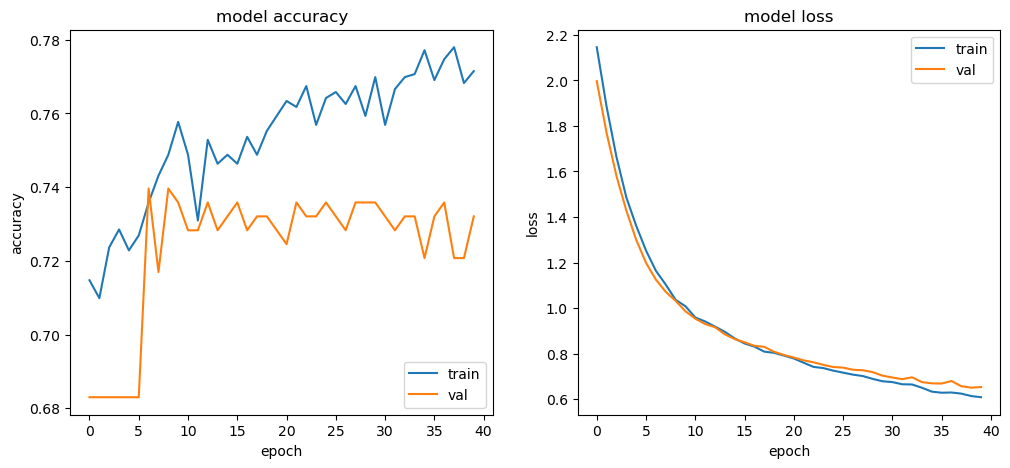

In [31]:
plot_results(results)

#### I think finally everything seem to be better and the loss functions looks very good. In this case, there is clearly a healthy correlation between training loss and the validation loss. They both seem to reduce and stay at a constant value. This means that the model is well trained and is equally good on the training data as well as the validation data. However we can still try some strategies to increase the accuracy.

#### Learning Rate Schedule 

In [32]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    return 0.001 * 0.9 ** epoch

lr_scheduler = LearningRateScheduler(lr_schedule)

results = model.fit(train_images, 
             train_labels, 
             epochs=40,
             batch_size=30,
             validation_data=(valid_images, valid_labels),
             callbacks=[lr_scheduler])

Epoch 1/40
42/42 [==============================] - 7s 164ms/step - loss: 0.6550 - accuracy: 0.7528 - val_loss: 0.6864 - val_accuracy: 0.6906 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - 7s 160ms/step - loss: 0.6242 - accuracy: 0.7431 - val_loss: 0.6220 - val_accuracy: 0.7396 - lr: 9.0000e-04
Epoch 3/40
42/42 [==============================] - 7s 155ms/step - loss: 0.5838 - accuracy: 0.7618 - val_loss: 0.6035 - val_accuracy: 0.7245 - lr: 8.1000e-04
Epoch 4/40
42/42 [==============================] - 6s 151ms/step - loss: 0.5692 - accuracy: 0.7699 - val_loss: 0.6022 - val_accuracy: 0.7358 - lr: 7.2900e-04
Epoch 5/40
42/42 [==============================] - 6s 152ms/step - loss: 0.5730 - accuracy: 0.7601 - val_loss: 0.5988 - val_accuracy: 0.7283 - lr: 6.5610e-04
Epoch 6/40
42/42 [==============================] - 6s 154ms/step - loss: 0.5523 - accuracy: 0.7569 - val_loss: 0.5940 - val_accuracy: 0.7321 - lr: 5.9049e-04
Epoch 7/40
42/42 [==============================] 

Maximum Loss : 0.6550

Minimum Loss : 0.3716

Loss difference : 0.2835


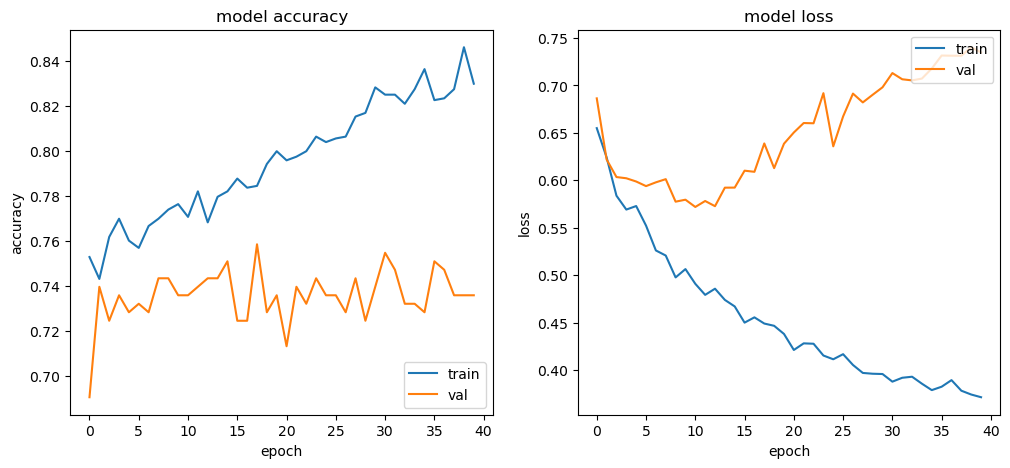

In [33]:
plot_results(results)

#### Not a good solution at all for the reasons that i told before.

#### Batch Normalization

In [34]:
# First create the empty model
model = Sequential()

# Very important to clear the session to avoid mixing up with and being affetced by previous computations 
tf.keras.backend.clear_session()

# First convolutional layers gets the input which is resolution and channels in our case -> (128,128,3)
# Using MaxPooling => reduce the spatial dimensions of the input,while retaining the most important information
model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu', input_shape=train_images[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(32, 3, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(64, 3, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(128, 3, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Flatten())

# Using drop which out is another regularization technique
# dropout rate = 0.45 ==> 45% of the input units will be randomly set to zero (Drop)
# Adding the kernel regulizer,l2 and increasing dropout rate
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [35]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
results = model.fit(train_images, 
             train_labels, 
             epochs=40,
             batch_size=30,
             validation_data=(valid_images, valid_labels))

Epoch 1/40
42/42 [==============================] - 16s 216ms/step - loss: 2.5570 - accuracy: 0.5600 - val_loss: 2.5362 - val_accuracy: 0.3170
Epoch 2/40
42/42 [==============================] - 8s 192ms/step - loss: 2.4702 - accuracy: 0.5924 - val_loss: 2.6838 - val_accuracy: 0.3170
Epoch 3/40
42/42 [==============================] - 8s 193ms/step - loss: 2.4522 - accuracy: 0.5818 - val_loss: 2.7271 - val_accuracy: 0.3170
Epoch 4/40
42/42 [==============================] - 8s 194ms/step - loss: 2.3842 - accuracy: 0.6110 - val_loss: 2.6697 - val_accuracy: 0.3170
Epoch 5/40
42/42 [==============================] - 8s 189ms/step - loss: 2.3887 - accuracy: 0.6256 - val_loss: 2.6566 - val_accuracy: 0.3170
Epoch 6/40
42/42 [==============================] - 8s 192ms/step - loss: 2.3633 - accuracy: 0.6045 - val_loss: 2.5212 - val_accuracy: 0.3170
Epoch 7/40
42/42 [==============================] - 8s 193ms/step - loss: 2.3269 - accuracy: 0.6102 - val_loss: 2.5639 - val_accuracy: 0.3170
Epoch

Maximum Loss : 2.5570

Minimum Loss : 1.6191

Loss difference : 0.9379


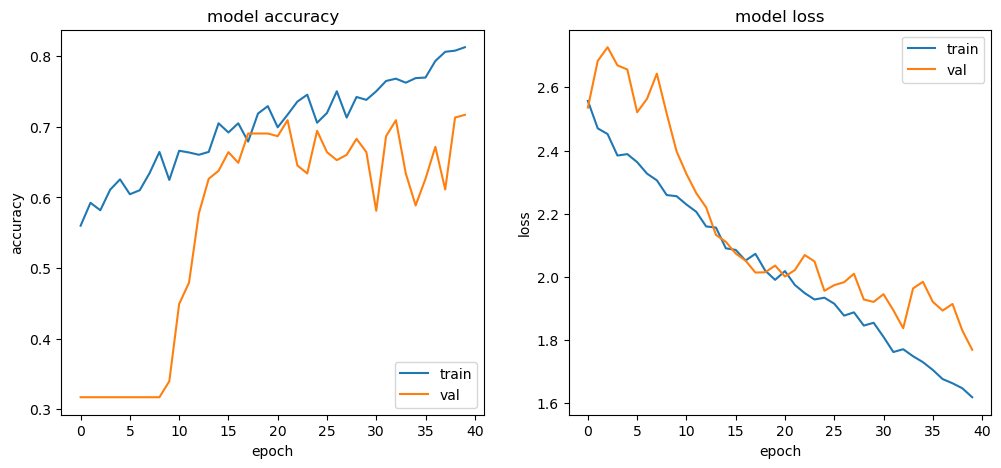

In [36]:
plot_results(results)

#### Same problems, doesnt look a good solution at all i will move further with another technique

#### Weight Initialization

In [37]:
from tensorflow.keras.initializers import he_normal

# First create the empty model
model = Sequential()

# Very important to clear the session to avoid mixing up with and being affetced by previous computations 
tf.keras.backend.clear_session()

# First convolutional layers gets the input which is resolution and channels in our case -> (128,128,3)
# Using MaxPooling => reduce the spatial dimensions of the input,while retaining the most important information
model.add(Conv2D(32, 3, kernel_initializer=he_normal(), activation='relu', input_shape=train_images[0].shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(32, 3, kernel_initializer=he_normal(), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(64, 3, kernel_initializer=he_normal(), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(128, 3, kernel_initializer=he_normal(), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Flatten())

# Using drop which out is another regularization technique
# dropout rate = 0.45 ==> 45% of the input units will be randomly set to zero (Drop)
# Adding the kernel regulizer,l2 and increasing dropout rate
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
results = model.fit(train_images, 
             train_labels, 
             epochs=40,
             batch_size=30,
             validation_data=(valid_images, valid_labels))

Epoch 1/40
42/42 [==============================] - 11s 164ms/step - loss: 2.2796 - accuracy: 0.6159 - val_loss: 2.0603 - val_accuracy: 0.6830
Epoch 2/40
42/42 [==============================] - 6s 153ms/step - loss: 1.9759 - accuracy: 0.6669 - val_loss: 1.8584 - val_accuracy: 0.6830
Epoch 3/40
42/42 [==============================] - 7s 155ms/step - loss: 1.7954 - accuracy: 0.6864 - val_loss: 1.6984 - val_accuracy: 0.6830
Epoch 4/40
42/42 [==============================] - 6s 153ms/step - loss: 1.6606 - accuracy: 0.6637 - val_loss: 1.5654 - val_accuracy: 0.6830
Epoch 5/40
42/42 [==============================] - 6s 151ms/step - loss: 1.5300 - accuracy: 0.6864 - val_loss: 1.4552 - val_accuracy: 0.6830
Epoch 6/40
42/42 [==============================] - 6s 152ms/step - loss: 1.4290 - accuracy: 0.7034 - val_loss: 1.3689 - val_accuracy: 0.6830
Epoch 7/40
42/42 [==============================] - 6s 152ms/step - loss: 1.3568 - accuracy: 0.7042 - val_loss: 1.2994 - val_accuracy: 0.6830
Epoch

Maximum Loss : 2.2796

Minimum Loss : 0.6464

Loss difference : 1.6332


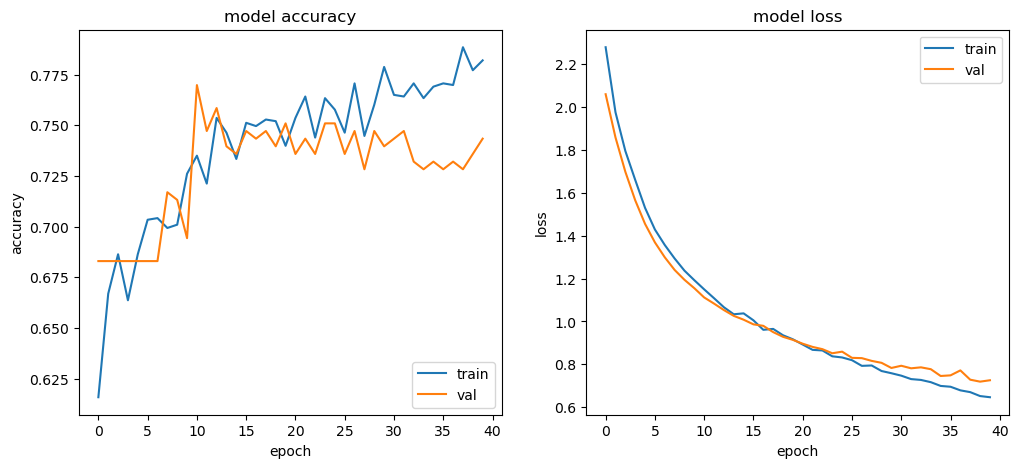

In [39]:
plot_results(results)

#### Seems like it's getting better the validation accuracy is getting closer to train accuracy as well as the loss which is a great sign. I think this is the moment that i will give up cause approximately i did whatever i knew but i know there are lotfs of other things that we can do to modify our model. At the end i will save the model and do the prediction on the test data to check wether it has the same accuracy of our model which is about 75%. The closer this two number, the better because a huge difference may indicate the overfitting of our model

In [62]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

loaded_model = load_model("final_version")

predictions = loaded_model.predict(test_images)

# Convert the predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_labels, binary_predictions)

print(f"Accuracy: {accuracy}")

9/9 [==============================] - 1s 49ms/step
Accuracy: 0.7358490566037735
